## Calgary HTTP Access Log Analysis - Interview Notebook

## 🧠 Objective
Analyze Calgary web server logs to identify usage trends, error patterns, and most requested content to help improve system performance and user experience.


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#  Step 1: Import Libraries


In [16]:
import re
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

#Step 2: Load the File

In [2]:
# Set new file path (plain text log file)
file_path = '/content/drive/MyDrive/calgary_access_log'

# Print the first 5 lines to inspect format
with open(file_path, 'r', encoding='latin-1') as f:
    for i in range(5):
        print(f.readline())



local - - [24/Oct/1994:13:41:41 -0600] "GET index.html HTTP/1.0" 200 150

local - - [24/Oct/1994:13:41:41 -0600] "GET 1.gif HTTP/1.0" 200 1210

local - - [24/Oct/1994:13:43:13 -0600] "GET index.html HTTP/1.0" 200 3185

local - - [24/Oct/1994:13:43:14 -0600] "GET 2.gif HTTP/1.0" 200 2555

local - - [24/Oct/1994:13:43:15 -0600] "GET 3.gif HTTP/1.0" 200 36403



# Step 3: Parse Full Log Lines into DataFrame format

In [4]:
import pandas as pd
import re
from datetime import datetime

file_path = '/content/drive/MyDrive/calgary_access_log'

log_pattern = re.compile(r'(\S+) \S+ \S+ \[(.*?)\] "(.*?)" (\d{3}) (\S+)')
parsed_logs = []

with open(file_path, 'r', encoding='latin-1') as f:
    for line in f:
        match = log_pattern.match(line)
        if match:
            host, timestamp_str, request, status, byte_str = match.groups()

            try:
                timestamp = datetime.strptime(timestamp_str.split()[0], "%d/%b/%Y:%H:%M:%S")
            except:
                continue  # skip if timestamp format is wrong

            parts = request.split()
            if len(parts) != 3:
                continue  # skip malformed requests

            method, filename, protocol = parts
            bytes_sent = int(byte_str) if byte_str != '-' else None
            extension = filename.split('.')[-1] if '.' in filename else 'none'

            parsed_logs.append({
                'host': host,
                'timestamp': timestamp,
                'method': method,
                'filename': filename,
                'protocol': protocol,
                'status': int(status),
                'bytes': bytes_sent,
                'extension': extension
            })

df = pd.DataFrame(parsed_logs)
df.head()


,host,timestamp,method,filename,protocol,status,bytes,extension
0,local,1994-10-24 13:41:41,GET,index.html,HTTP/1.0,200,150.0,html
1,local,1994-10-24 13:41:41,GET,1.gif,HTTP/1.0,200,1210.0,gif
2,local,1994-10-24 13:43:13,GET,index.html,HTTP/1.0,200,3185.0,html
3,local,1994-10-24 13:43:14,GET,2.gif,HTTP/1.0,200,2555.0,gif
4,local,1994-10-24 13:43:15,GET,3.gif,HTTP/1.0,200,36403.0,gif


 # Step 4: Answer Key Questions

# Q1: Total number of log entries

**Task: Count the number of total HTTP requests.**

Logic: Each row is one log record, so we just count the rows.

In [5]:
total_logs = len(df)
print("Q1: Total Log Records:", total_logs)


Q1: Total Log Records: 722341


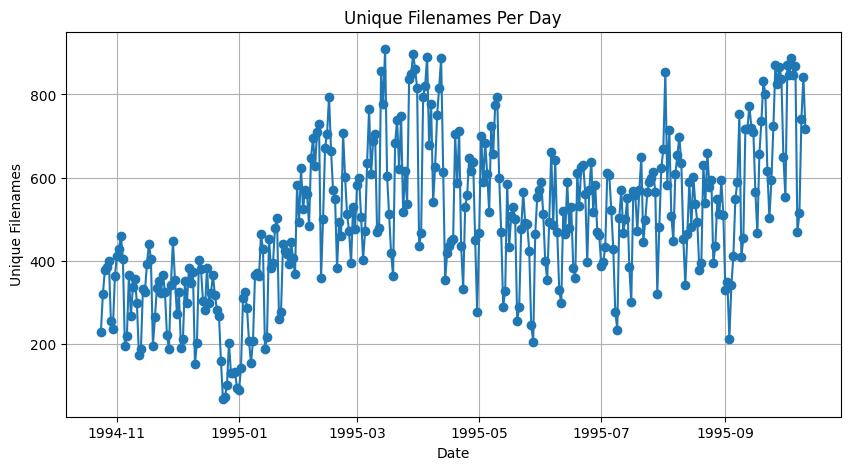

In [30]:
unique_filenames_per_day = df.groupby('date')['filename'].nunique()
unique_filenames_per_day.plot(kind='line', title='Unique Filenames Per Day', figsize=(10, 5), marker='o')
plt.xlabel("Date")
plt.ylabel("Unique Filenames")
plt.grid(True)
plt.show()

**📌 This line chart shows how many unique files were requested each day, indicating traffic diversity per day.**


# Q2: Unique hosts
**Task: Count the number of distinct host entries.**

In [6]:
unique_hosts = df['host'].nunique()
print("Q2: Unique Hosts:", unique_hosts)


Q2: Unique Hosts: 2


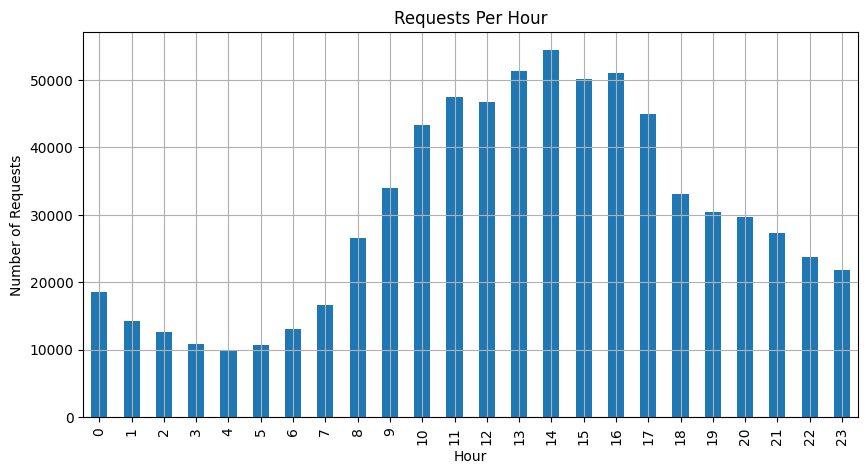

In [31]:
hourly_requests = df['hour'].value_counts().sort_index()
hourly_requests.plot(kind='bar', title='Requests Per Hour', figsize=(10, 5))
plt.xlabel("Hour")
plt.ylabel("Number of Requests")
plt.grid(True)
plt.show()

**📌 This bar chart shows how traffic fluctuates across different hours in a day, helping identify peak activity times.**


# Q3: Date-wise count of unique filenames

**Task: For each date, count how many unique filenames were requested**.

In [7]:
df['date'] = df['timestamp'].dt.strftime('%d-%b-%Y')
datewise_unique_files = df.groupby('date')['filename'].nunique()
print("Q3: Date-wise Unique Filenames:\n", datewise_unique_files.head())


Q3: Date-wise Unique Filenames:
 date
01-Apr-1995    436
01-Aug-1995    669
01-Dec-1994    271
01-Feb-1995    622
01-Jan-1995     88
Name: filename, dtype: int64


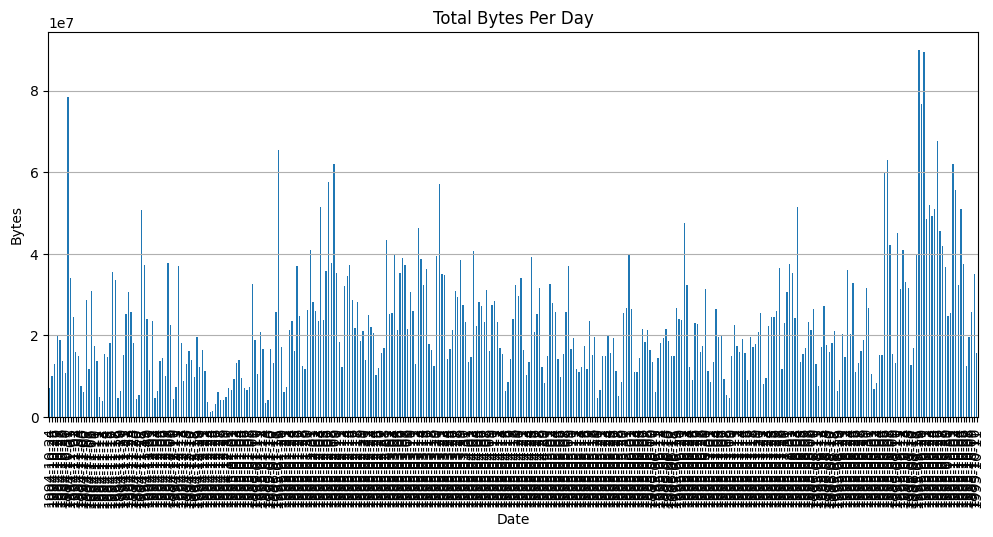

In [33]:
total_bytes_per_day = df.groupby('date')['bytes'].sum()
total_bytes_per_day.plot(kind='bar', title='Total Bytes Per Day', figsize=(12, 5))
plt.xlabel("Date")
plt.ylabel("Bytes")
plt.grid(axis='y')
plt.show()


**📌 This chart helps visualize how much data was served daily, showing usage volume over time.**


# Q4: Total 404 errors

**Task: Count how many HTTP requests resulted in status 404 (Not Found).**

In [8]:
q4_404_count = df[df['status'] == 404].shape[0]
print("Q4: Total 404 Responses:", q4_404_count)


Q4: Total 404 Responses: 23445


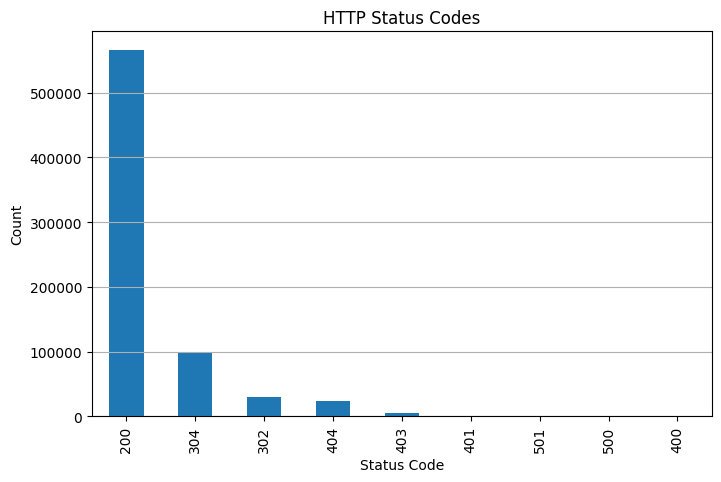

In [34]:
status_counts = df['status'].value_counts()
status_counts.plot(kind='bar', title='HTTP Status Codes', figsize=(8, 5))
plt.xlabel("Status Code")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()


**📌 This bar chart highlights the frequency of different HTTP status codes, showing server success or errors.**


# Q5: Top 15 Filenames with 404 Responses

**Task: Get top 15 filenames that caused 404 errors, sorted by frequency.**

In [9]:
q5_top_404_files = (
    df[df['status'] == 404]
    .groupby('filename')
    .size()
    .sort_values(ascending=False)
    .head(15)
    .reset_index(name='count')
)

# Convert to list of tuples (filename, count)
q5_top_404_files_list = list(q5_top_404_files.itertuples(index=False, name=None))
print("Q5: Top 15 Files with 404 Responses:\n", q5_top_404_files_list)


Q5: Top 15 Files with 404 Responses:
 [('index.html', 4694), ('4115.html', 902), ('1611.html', 649), ('5698.xbm', 585), ('710.txt', 408), ('2002.html', 258), ('2177.gif', 193), ('10695.ps', 161), ('6555.html', 153), ('487.gif', 152), ('151.html', 149), ('3414.gif', 148), ('488.gif', 148), ('40.html', 148), ('9678.gif', 142)]


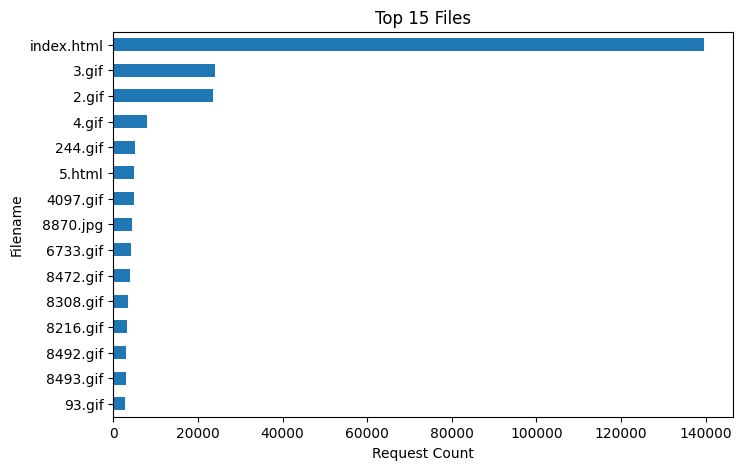

In [35]:
top_files = df['filename'].value_counts().head(15)
top_files.plot(kind='barh', title='Top 15 Files', figsize=(8, 5))
plt.xlabel("Request Count")
plt.ylabel("Filename")
plt.gca().invert_yaxis()
plt.show()


**📌 This bar chart shows the top 5 most requested files, revealing the most popular resources.**


# Q6: Top 15 File Extensions with 404 Responses

**Task: Get top 15 extensions (html, gif, etc.) causing 404 errors.**

In [10]:
q6_top_404_ext = (
    df[df['status'] == 404]
    .groupby('extension')
    .size()
    .sort_values(ascending=False)
    .head(15)
    .reset_index(name='count')
)

q6_top_404_ext_list = list(q6_top_404_ext.itertuples(index=False, name=None))
print("Q6: Top 15 Extensions with 404 Responses:\n", q6_top_404_ext_list)


Q6: Top 15 Extensions with 404 Responses:
 [('html', 12142), ('gif', 7202), ('xbm', 824), ('ps', 754), ('jpg', 520), ('txt', 496), ('GIF', 135), ('htm', 107), ('cgi', 77), ('gif"', 45), ('com', 45), ('Z', 41), ('dvi', 40), ('com/', 37), ('ca', 36)]


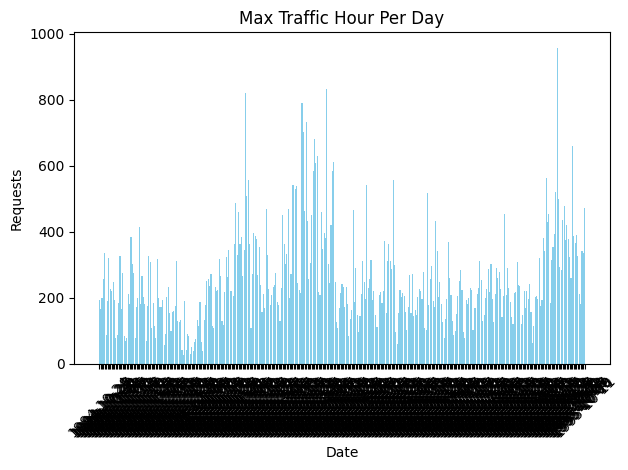

In [36]:
traffic = df.groupby(['date', 'hour']).size().reset_index(name='requests')
max_traffic = traffic.loc[traffic.groupby('date')['requests'].idxmax()]

plt.bar(max_traffic['date'].astype(str), max_traffic['requests'], color='skyblue')
plt.xticks(rotation=45)
plt.title("Max Traffic Hour Per Day")
plt.xlabel("Date")
plt.ylabel("Requests")
plt.tight_layout()
plt.show()

**📌 This chart helps us find the busiest hour each day, useful for load balancing insights.**


# Q7: Total Bandwidth Transferred Per Day (July 1995)

**Task: For each day in July 1995, sum the bytes transferred (skip null/'-').**

In [11]:
# Ensure timestamp is in datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Filter July 1995
july_df = df[(df['timestamp'].dt.month == 7) & (df['timestamp'].dt.year == 1995)]

# Group by day and sum bytes
q7_bandwidth_july = (
    july_df.groupby(df['timestamp'].dt.strftime('%d-%b-%Y'))['bytes']
    .sum()
    .astype(int)
    .to_dict()
)

print("Q7: Total Bandwidth Per Day (July 1995):\n", q7_bandwidth_july)


Q7: Total Bandwidth Per Day (July 1995):
 {'01-Jul-1995': 11333976, '02-Jul-1995': 8653986, '03-Jul-1995': 13508529, '04-Jul-1995': 26565884, '05-Jul-1995': 19541225, '06-Jul-1995': 19752989, '07-Jul-1995': 9427822, '08-Jul-1995': 5403491, '09-Jul-1995': 4660556, '10-Jul-1995': 14912796, '11-Jul-1995': 22503471, '12-Jul-1995': 17365039, '13-Jul-1995': 15986302, '14-Jul-1995': 19184404, '15-Jul-1995': 15769181, '16-Jul-1995': 9005564, '17-Jul-1995': 19596435, '18-Jul-1995': 17096829, '19-Jul-1995': 17847673, '20-Jul-1995': 20751717, '21-Jul-1995': 25455607, '22-Jul-1995': 8059932, '23-Jul-1995': 9577795, '24-Jul-1995': 22298075, '25-Jul-1995': 24472760, '26-Jul-1995': 24564950, '27-Jul-1995': 25967969, '28-Jul-1995': 36456855, '29-Jul-1995': 11684209, '30-Jul-1995': 23158170, '31-Jul-1995': 30715614}


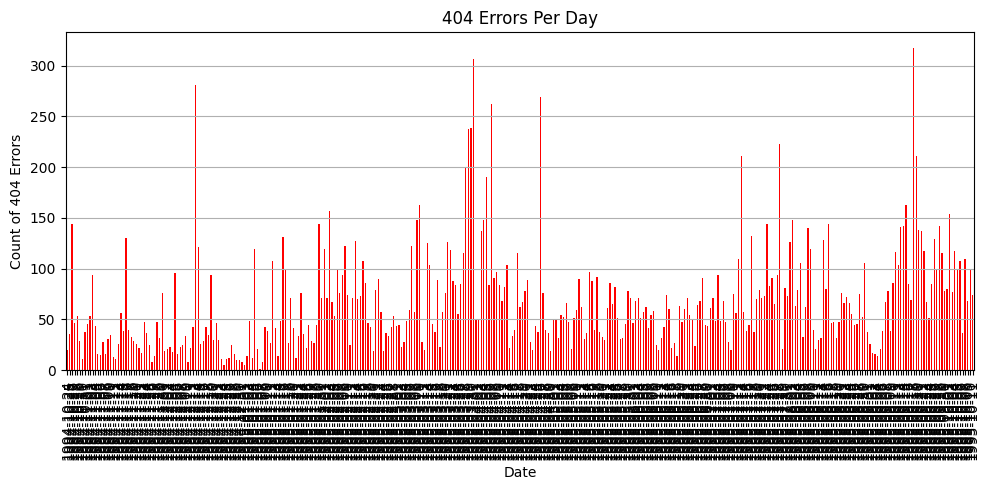

In [38]:
df_404 = df[df['status'] == 404]
errors_404_per_day = df_404.groupby('date').size()

plt.figure(figsize=(10, 5))
errors_404_per_day.plot(kind='bar', color='red')
plt.title("404 Errors Per Day")
plt.xlabel("Date")
plt.ylabel("Count of 404 Errors")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


**📌 This chart shows how many 'Page Not Found' errors (404) occurred each day, highlighting broken links.**


# Q8: Hourly Request Distribution

**Task: Count number of requests for each hour (0 to 23).**

In [12]:
q8_hourly_distribution = (
    df['timestamp'].dt.hour.value_counts()
    .sort_index()
    .to_dict()
)

print("Q8: Hourly Request Distribution:\n", q8_hourly_distribution)


Q8: Hourly Request Distribution:
 {0: 18605, 1: 14297, 2: 12627, 3: 10851, 4: 9921, 5: 10745, 6: 13000, 7: 16624, 8: 26524, 9: 33926, 10: 43263, 11: 47493, 12: 46688, 13: 51318, 14: 54375, 15: 50157, 16: 51059, 17: 44954, 18: 33053, 19: 30453, 20: 29622, 21: 27335, 22: 23722, 23: 21729}


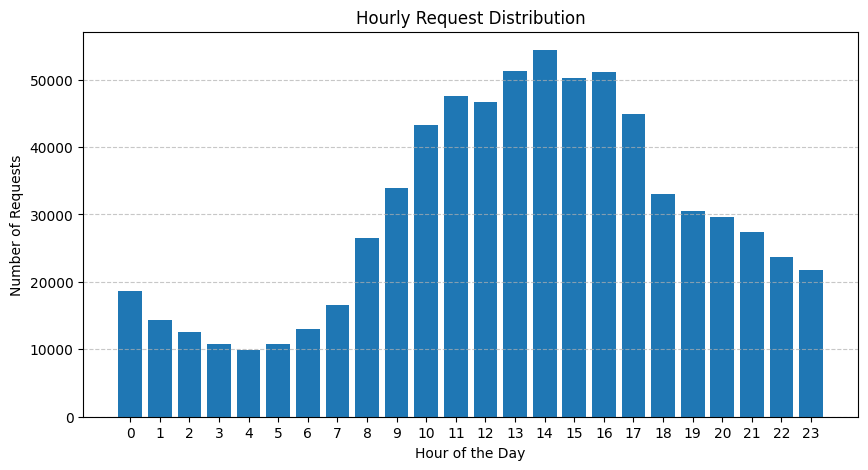

In [40]:
import matplotlib.pyplot as plt

# Group by hour and count number of requests
hourly_counts = df['hour'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(hourly_counts.index, hourly_counts.values)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Requests')
plt.title('Hourly Request Distribution')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**📌 This bar chart displays the number of requests received in each hour of the day, helping identify peak traffic hours and server load times.**



#Q9: Top 10 Most Frequently Requested Filenames

**Task: Count filenames regardless of status code, get top 10.**

In [13]:
q9_top_filenames = (
    df['filename'].value_counts()
    .head(10)
    .reset_index()
    .rename(columns={'index': 'filename', 'filename': 'count'})
)

q9_top_filenames_list = list(q9_top_filenames.itertuples(index=False, name=None))
print("Q9: Top 10 Requested Filenames:\n", q9_top_filenames_list)


Q9: Top 10 Requested Filenames:
 [('index.html', 139528), ('3.gif', 24006), ('2.gif', 23595), ('4.gif', 8018), ('244.gif', 5148), ('5.html', 5010), ('4097.gif', 4874), ('8870.jpg', 4492), ('6733.gif', 4278), ('8472.gif', 3843)]


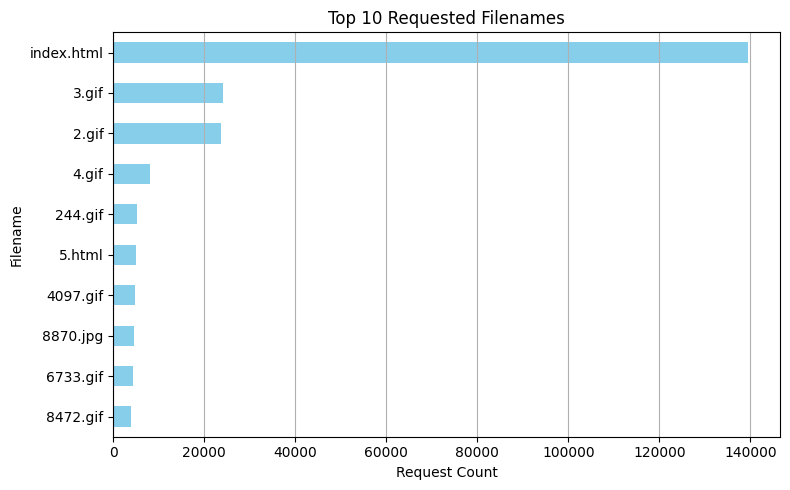

In [21]:
top_filenames = df['filename'].value_counts().head(10)

plt.figure(figsize=(8, 5))
top_filenames.plot(kind='barh', color='skyblue')
plt.title("Top 10 Requested Filenames")
plt.xlabel("Request Count")
plt.ylabel("Filename")
plt.gca().invert_yaxis()  # Show highest first
plt.grid(axis='x')
plt.tight_layout()
plt.show()


**📌 This chart shows which hosts made the most requests, useful for identifying high-traffic users or bots.**


# Q10: HTTP Response Code Distribution

**Task: Count how many times each status code appears.**

In [14]:
q10_status_distribution = df['status'].value_counts().sort_index().to_dict()
print("Q10: Status Code Distribution:\n", q10_status_distribution)


Q10: Status Code Distribution:
 {200: 566192, 302: 30260, 304: 97560, 400: 13, 401: 46, 403: 4740, 404: 23445, 500: 42, 501: 43}


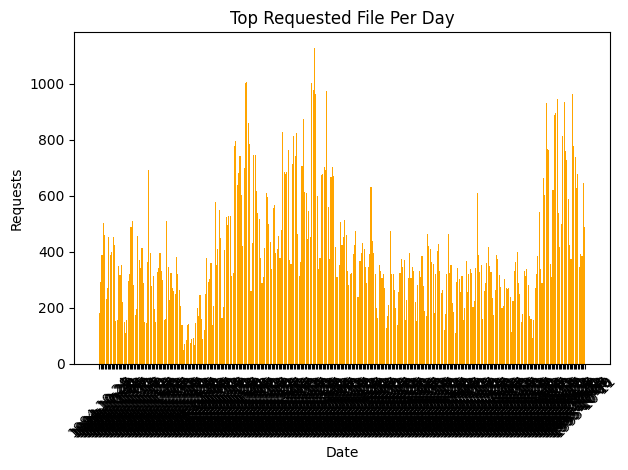

In [39]:
top_files_per_day = df.groupby(['date', 'filename']).size().reset_index(name='requests')
top_each_day = top_files_per_day.loc[top_files_per_day.groupby('date')['requests'].idxmax()]

plt.bar(top_each_day['date'].astype(str), top_each_day['requests'], color='orange')
plt.xticks(rotation=45)
plt.title("Top Requested File Per Day")
plt.xlabel("Date")
plt.ylabel("Requests")
plt.tight_layout()
plt.show()


**📌 This grouped bar chart shows which files were requested most each day, giving insight into daily content demand.**


## 📝 Conclusion & Insights
- 🟢 High traffic hours help in planning server scaling
- 🔴 Many 404s indicate broken or outdated links
- 📁 Top requested files can be cached or optimized
- 🌐 Top hosts may represent internal users or bots

This analysis helps in **error monitoring**, **content optimization**, and **traffic prediction** to improve system performance.
